# Training dataset

In [1]:
#!pip install nltk
#!pip install text2num

In [2]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')
from utils_processor.processor import Processor
import logging

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\USUARIO\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USUARIO\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\USUARIO\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [3]:
processor_ = Processor()

In [4]:
import os

# Directorio donde están los archivos .txt
data_dir = 'data/books/'

# Leer todos los archivos .txt del directorio
texts = []
for filename in os.listdir(data_dir):
    if filename.endswith('.txt'):
        print(filename)
        with open(os.path.join(data_dir, filename), 'r', encoding='utf-8') as f:
            texts.append(f.read())
            print(f.read()[:2500])

ATaleofTwoCities_Dickens.txt

BleakHouse_Dickens.txt

CountofMonteCristo_Dumas.txt

CrimeAndPunishment_dostoyevski.txt

OliverTwist_Dickens.txt

TheGambler_dostoyevski.txt

TheIdiot_dostoyevski.txt

TheThreeMusketeers_Dumas.txt

TwentyYearsAfter_Dumas.txt



In [5]:
def process_all_texts(processor, texts):
    """
    Processes a list of texts and logs progress for each one, using the Processor class.
    
    Args:
        processor (Processor): An instance of the Processor class.
        texts (list): A list of text strings to process.
    
    Returns:
        list: A list of processed texts.
    """
    total = len(texts)
    processed_texts = []
    
    for index, text in enumerate(texts):
        processed_text = processor.preprocessing_pipeline(text, index, total)
        processed_texts.append(processed_text)  # Guardamos el texto procesado como lista de tokens
    
    return processed_texts

In [6]:
# Procesar todos los textos con el sistema de logging
processed_texts = process_all_texts(processor_, texts)

In [7]:
len(processed_texts)

9

In [8]:
def get_vocabulary_size(processed_texts):
    """
    Calculates the size of the vocabulary from a list of processed texts (tokenized).
    
    Args:
        processed_texts (list): A list of lists where each inner list represents tokenized words from a text.
        
    Returns:
        int: The size of the unique vocabulary (number of unique words).
    """
    vocabulary = set()
    
    for text in processed_texts:
        vocabulary.update(text)  # Add unique words from the current text to the vocabulary set
    
    return len(vocabulary)

# processed_texts = [...]  # Lista de textos preprocesados (tokenizados)
vocab_size = get_vocabulary_size(processed_texts)

print(f"Tamaño del vocabulario: {vocab_size}")


Tamaño del vocabulario: 27219


In [9]:
from gensim.models import Word2Vec

def train_and_save_models(processed_texts, dimensions=[1000, 5000, 10000], group_code=6):
    """
    Trains Word2Vec models with different embedding dimensions and saves them to disk.
    
    Args:
        processed_texts (list): A list of preprocessed texts (tokenized and cleaned).
        dimensions (list): A list of integers representing the embedding dimensions to try.
        group_code (int): The code for the group, used in the file naming convention.
    """
    for size in dimensions:
        # Train Word2Vec model with the specified embedding size
        print(f"Training model with dimensionality {size}")
        model = Word2Vec(sentences=processed_texts, vector_size=size, window=5, min_count=1, workers=4)
        
        # Create the file name based on the group code and embedding size
        model_filename = f"data/answers/Books_{size}_{group_code}.model"
        
        # Save the model to disk
        model.save(model_filename)
        print(f"Model saved as {model_filename}")


train_and_save_models(processed_texts=processed_texts)


Training model with dimensionality 1000
Model saved as data/answers/Books_1000_6.model
Training model with dimensionality 5000
Model saved as data/answers/Books_5000_6.model
Training model with dimensionality 10000
Model saved as data/answers/Books_10000_6.model



Para visualizar embeddings en dos dimensiones y explorar relaciones entre palabras, puedes seguir esta estrategia utilizando técnicas comunes de reducción de dimensionalidad, como PCA (Análisis de Componentes Principales) o t-SNE (t-Distributed Stochastic Neighbor Embedding). Estas técnicas permiten proyectar los embeddings de alta dimensionalidad (como los de Word2Vec) en un espacio de dos dimensiones para su visualización.

Estrategia general para visualizar embeddings en 2D:
Entrenar el modelo Word2Vec: Asegúrate de que ya tienes entrenado el modelo Word2Vec, que ha aprendido los vectores de las palabras del texto.

### Seleccionar las palabras relevantes:

Identificar los nombres de los personajes principales de cada libro.
Busca las palabras más similares a estos personajes en el espacio de embeddings utilizando la función most_similar() de Word2Vec.
Reducción de dimensionalidad:

Usa PCA o t-SNE para reducir los vectores de las palabras seleccionadas a 2 dimensiones. Esto hará que puedas graficar las palabras en un espacio bidimensional.
Visualización:

Utiliza bibliotecas como matplotlib para graficar los embeddings en 2D.
Resalta los nombres de los personajes principales y sus palabras más similares.

In [10]:
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np

def plot_embeddings_2d(model, target_words, method='pca', n_similar=10):
    words = []
    word_vectors = []
    
    # Add target words and their most similar words
    for word in target_words:
        if word in model.wv:
            # Add the main word
            words.append(word)
            word_vectors.append(model.wv[word])
            
            # Add the most similar words
            similar_words = model.wv.most_similar(word, topn=n_similar)
            for similar_word, _ in similar_words:
                words.append(similar_word)
                word_vectors.append(model.wv[similar_word])
        else:
            print(f"{word} no está en el vocabulario, omitiendo...")
    
    # Si no hay palabras suficientes para graficar
    if len(word_vectors) == 0:
        print("No se encontraron palabras para graficar.")
        return
    
    # Convert list to numpy array for PCA or t-SNE
    word_vectors = np.array(word_vectors)
    
    # Apply dimensionality reduction
    if method == 'pca':
        pca = PCA(n_components=2)
        word_vecs_2d = pca.fit_transform(word_vectors)
    elif method == 'tsne':
        tsne = TSNE(n_components=2, random_state=42)
        word_vecs_2d = tsne.fit_transform(word_vectors)
    
    # Plot the words
    plt.figure(figsize=(12, 8))
    plt.scatter(word_vecs_2d[:, 0], word_vecs_2d[:, 1], c='blue')

    # Annotate the points with the words
    for i, word in enumerate(words):
        plt.annotate(word, (word_vecs_2d[i, 0], word_vecs_2d[i, 1]))
    
    plt.title(f'2D Word Embeddings Visualization using {method.upper()}')
    plt.show()

# Ahora ejecutar



In [11]:
# Cargar uno de tus modelos guardados
model_1000d = Word2Vec.load('data/answers/Books_1000_6.model')
model_5000d = Word2Vec.load('data/answers/Books_5000_6.model')
model_10000d = Word2Vec.load('data/answers/Books_10000_6.model')

# Ejemplo de personajes para Crime and Punishment
main_characters = ['raskolnikov', 'rodya', 'porfiry', 'Razumihin'] 
main_characters = processor_.preprocessing_pipeline(main_characters)


Error cleaning Gutenberg text: Start of the Project Gutenberg ebook not found


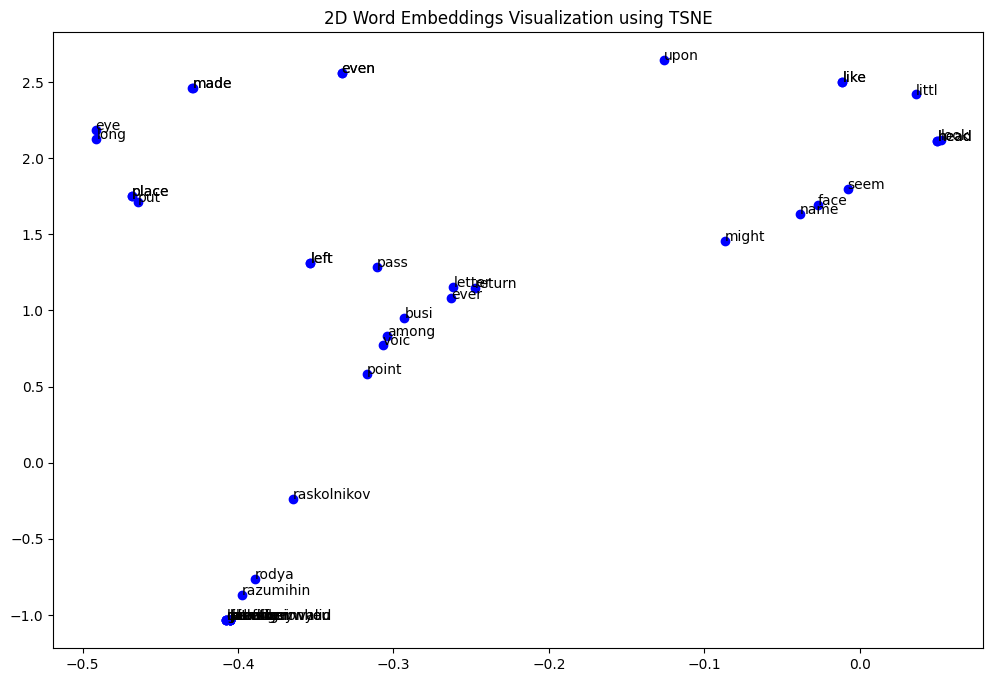

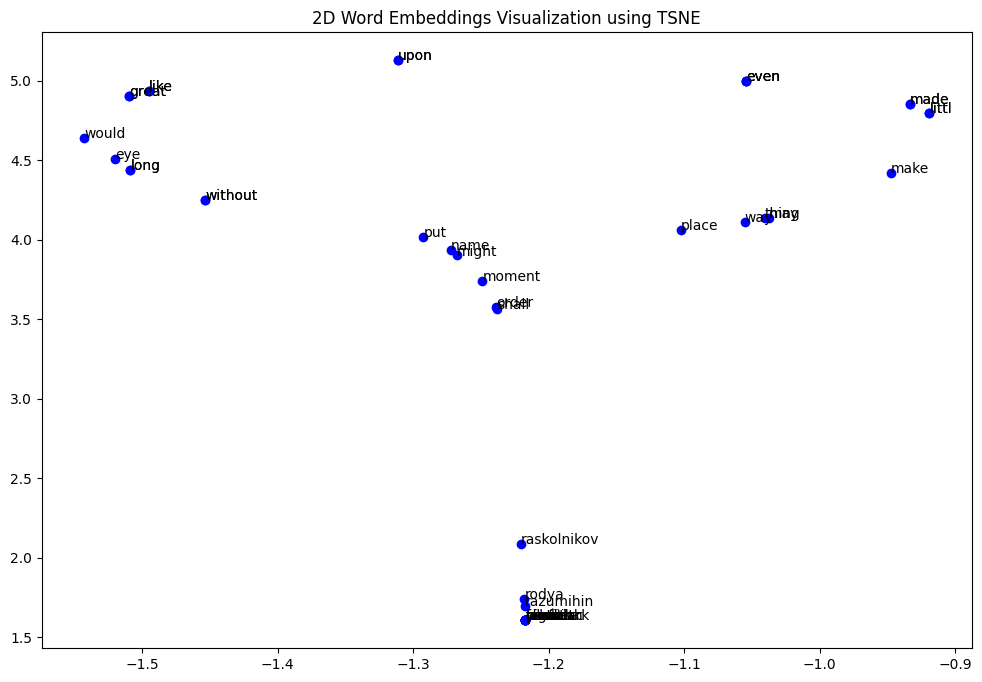

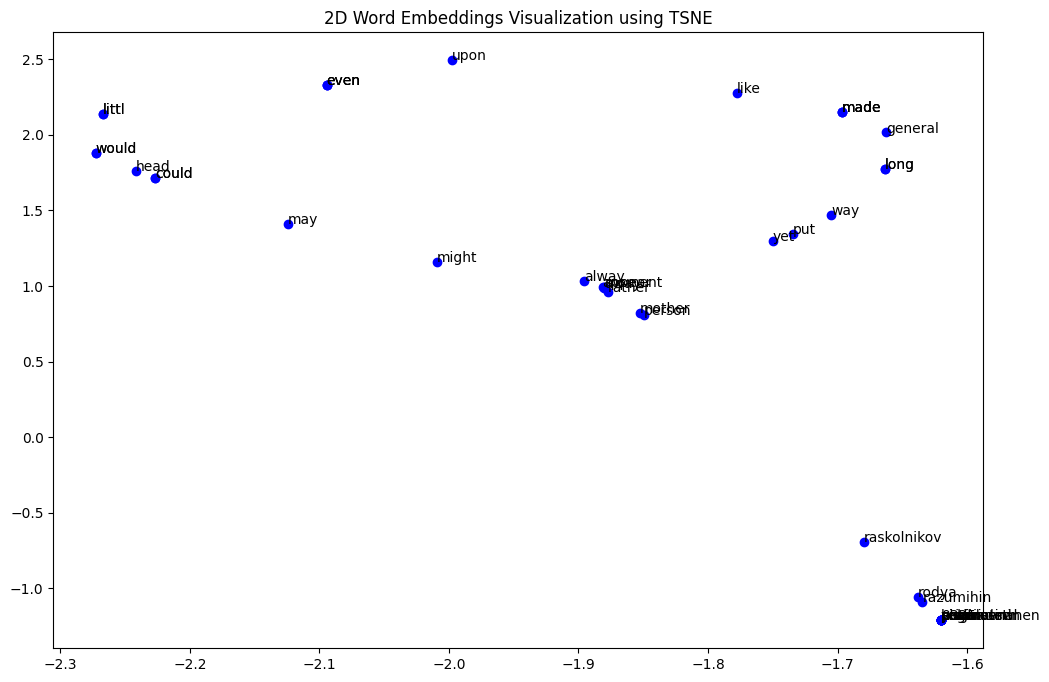

: 

In [12]:

# Visualizar embeddings usando t-SNE
plot_embeddings_2d(model_1000d, target_words=main_characters, method='tsne')
plot_embeddings_2d(model_5000d, target_words=main_characters, method='tsne')
plot_embeddings_2d(model_10000d, target_words=main_characters, method='tsne')